## Spectral clustering

Spectral clustering is a powerful technique for clustering data into groups based on their similarities. It utilizes the spectral properties of a similarity or affinity matrix derived from the data. This method is particularly useful when traditional clustering algorithms like K-means or hierarchical clustering are not effective due to the non-convex or complex structures within the data.

The key steps in spectral clustering are as follows:

1. **Similarity Matrix**: Calculate a similarity or affinity matrix that quantifies the relationships between data points. Common choices for similarity measures include nearest neighbors, radial basis function (RBF) kernel, or cosine similarity.

2. **Graph Representation**: Convert the similarity matrix into a graph representation, where each data point is a node, and the similarity values determine the edge weights between nodes. This graph is often referred to as a "similarity graph."

3. **Graph Laplacian**: Compute the Laplacian matrix of the graph, which encodes the graph's spectral properties. There are different types of Laplacian matrices, such as the unnormalized Laplacian, normalized Laplacian, or symmetric normalized Laplacian.

4. **Eigenvalue Decomposition**: Perform eigenvalue decomposition on the Laplacian matrix to obtain the eigenvectors and eigenvalues. These eigenvectors capture the spectral properties of the data.

5. **Dimension Reduction**: Select a subset of the eigenvectors (usually the first k eigenvectors) to represent the data in a lower-dimensional space. This step reduces the dimensionality of the data.

6. **Clustering**: Apply a traditional clustering algorithm (e.g., K-means or hierarchical clustering) to the reduced-dimensional data. The number of clusters is determined by the specific problem and is not constrained by the dimensionality of the data.

Spectral clustering is effective at identifying clusters with complex shapes and handling data that may not be linearly separable. It is widely used in image segmentation, community detection in networks, and various data analysis tasks where traditional clustering methods may fall short.

Keep in mind that spectral clustering's performance depends on parameters like the number of clusters and the choice of similarity measure. Experimentation and tuning are often required to obtain optimal results for your specific dataset.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pickle

import sys
import os
sys.path.append('../..')
from src.utils.directories import get_parent_directory
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [19]:
parent_dir = get_parent_directory()
all_pkl_path = (os.path.join(parent_dir, "data/processed/ml_ready/merged_all.pkl"))

with open(all_pkl_path, 'rb') as f:
    data = pickle.load(f)

In [20]:
# Count the rows where latitude is above 60 degrees or below -60 degrees
count_above_below = ((data['latitude'] > 60) | (data['latitude'] < -60)).sum()

# Calculate the number of rows that do not meet the conditions
count_not_above_below = len(data) - count_above_below

# Print the results
print("Rows with latitude above 60 degrees or below -60 degrees:", count_above_below)
print("Rows that do not meet the conditions:", count_not_above_below)


Rows with latitude above 60 degrees or below -60 degrees: 734212
Rows that do not meet the conditions: 354888


# clustering preparation

data = data[data['S'] >= 20]
data = data.dropna()

max_points_per_latitude = 5

# Subsample the DataFrame
subsampled_df = data.groupby('latitude', group_keys=False).apply(lambda group: group.sample(n=min(max_points_per_latitude, len(group)), random_state=42))

# Reset the index of the subsampled DataFrame
subsampled_df.reset_index(drop=True, inplace=True)

In [49]:
# Identify polar data (above 60 degrees)
polar_data = data[data['latitude'] > 60]

# Filter rows where 'S' is greater than or equal to 20
polar_data = polar_data[polar_data['S'] >= 20]

# Drop rows with NaN values
polar_data = polar_data.dropna()

max_points_per_latitude = 20

# Subsample the polar data
subsampled_polar_data = polar_data.groupby('latitude', group_keys=False).apply(lambda group: group.sample(n=min(max_points_per_latitude, len(group)), random_state=42))

# Reset the index of the subsampled data
subsampled_polar_data.reset_index(drop=True, inplace=True)

# Update the original DataFrame with the subsampled polar data
subsampled_df = data

subsampled_df.loc[data['latitude'] > 60] = subsampled_polar_data
subsampled_df = subsampled_df.dropna()

In [50]:
# Specify the percentage of data you want to keep (10%)
percentage_to_keep = 0.10

# Calculate the number of rows to keep
num_rows_to_keep = int(percentage_to_keep * len(subsampled_df))

# Randomly shuffle the DataFrame
shuffled_data = subsampled_df.sample(frac=1, random_state=1)  # frac=1 shuffles all rows

# Select the first 10% of the shuffled data
subsampled_df = shuffled_data.head(num_rows_to_keep)

In [51]:
# Count the rows where latitude is above 60 degrees or below -60 degrees
count_above_below = ((subsampled_df['latitude'] > 60) | (subsampled_df['latitude'] < -60)).sum()

# Calculate the number of rows that do not meet the conditions
count_not_above_below = len(subsampled_df) - count_above_below

# Print the results
print("Rows with latitude above 60 degrees or below -60 degrees:", count_above_below)
print("Rows that do not meet the conditions:", count_not_above_below)

Rows with latitude above 60 degrees or below -60 degrees: 7686
Rows that do not meet the conditions: 35425


In [52]:
var_df = subsampled_df[['S', 'T', 'log_eps', 'log_N2', 'dTdz', 'dSdz']]

# Keep the column names
column_names = var_df.columns

X = var_df

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add the column names back to the X_scaled array
X_scaled = pd.DataFrame(X_scaled, columns=column_names)

# Find optimal number of clusters

**Silhouette Score**:

The silhouette score is a metric used to evaluate the quality of clusters in a clustering analysis. It measures how similar each data point is to its own cluster (cohesion) compared to other clusters (separation). The silhouette score ranges from -1 to 1, where higher values indicate better clustering quality. The formula for calculating the silhouette score is as follows:

\[
\text{Silhouette Score} = \frac{b - a}{\max(a, b)}
\]

Where:
- \(a\) represents the average distance from a data point to other points in the same cluster (cohesion).
- \(b\) represents the minimum average distance from a data point to points in a different cluster (separation).

The silhouette score has the following interpretations:
- If the cohesion within the same cluster (\(a\)) is much smaller than the separation from other clusters (\(b\)), the silhouette score is close to 1, indicating that data points are well-matched to their own clusters.
- If the separation (\(b\)) is much smaller than the cohesion (\(a\)), the silhouette score is close to -1, suggesting that data points are poorly matched to their own clusters.
- A silhouette score near 0 indicates that a data point is near the decision boundary between two neighboring clusters.

In practice, a higher average silhouette score suggests better clustering, and the optimal number of clusters is often selected by comparing silhouette scores for different cluster numbers and choosing the number that maximizes the score. The silhouette score helps assess clustering quality and guide the selection of the appropriate number of clusters for the data.



In [15]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Create an array to store silhouette scores
silhouette_scores = []

# Define a range of cluster numbers to test
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Perform spectral clustering for different cluster numbers and record silhouette scores
for n_clusters in range_n_clusters:
    spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=10)
    cluster_labels = spectral_clustering.fit_predict(X_scaled)
    
    # Calculate the silhouette score and record it
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Create a plot for the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Spectral Clustering')
plt.show()


KeyboardInterrupt: 

## Perform spectral clustering

In [11]:
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import adjusted_rand_score, homogeneity_score

# Define a range of hyperparameters to search
param_grid = {
    'n_clusters': [3],  # Adjust the number of clusters
    'affinity': ['nearest_neighbors', 'rbf'],  # Experiment with different affinity measures
    'n_neighbors': [5, 10],  # Adjust the number of neighbors (if using nearest_neighbors)
}
# Instantiate the Spectral Clustering model
spectral_clustering = SpectralClustering()

# Use Grid Search to find the best combination of hyperparameters
grid_search = GridSearchCV(spectral_clustering, param_grid, scoring=adjusted_rand_score, n_jobs=-1)
grid_search.fit(X_scaled)  # Assuming X_scaled is your scaled data

# Get the best parameters and best adjusted Rand score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Adjusted Rand Score:", best_score)


/Users/Lisanne/opt/anaconda3/envs/arcticT/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/Lisanne/opt/anaconda3/envs/arcticT/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Lisanne/opt/anaconda3/envs/arcticT/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/Lisanne/opt/anaconda3/envs/arcticT/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py", line 401, in adjusted_rand_score
    (tn, fp), (fn, tp) = pair_confusion_matrix(labels_true, labels_pred)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

# Acually cluster
with 3

In [53]:
var_df = subsampled_df[['S', 'T', 'log_eps', 'log_N2', 'dTdz', 'dSdz']]

# Keep the column names
column_names = var_df.columns

X = var_df

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add the column names back to the X_scaled array
X_scaled = pd.DataFrame(X_scaled, columns=column_names)

In [54]:
X = X_scaled

from sklearn.cluster import SpectralClustering

# Instantiate the Spectral Clustering model
n_clusters = 3  # The number of clusters to form
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=20) #10
# spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='rbf', n_neighbors=10)

# Fit the Spectral Clustering model to your scaled data
cluster_labels = spectral_clustering.fit_predict(X_scaled)

# Evaluate clusters

In [55]:
X_input = X[['S', 'T', 'log_eps', 'log_N2', 'dTdz', 'dSdz']]
# X_output = X[['Cluster']]

# Use the inverse_transform method to anti-scale X_scaled
transformed_df = pd.DataFrame(scaler.inverse_transform(X_input), columns=X_input.columns)

# Add cluster labels to the DataFrame
transformed_df['Cluster'] = spectral_clustering.labels_

# Round the values in the DataFrames to a specific number of decimal places
decimals = 4  # Adjust as needed
data_rounded = data.round(decimals)
transformed_df_rounded = transformed_df.round(decimals)

# Merge based on multiple columns (A and B)
merged_df = transformed_df_rounded.merge(data_rounded, on=['S', 'T', 'log_eps', 'log_N2', 'dSdz', 'dTdz'], how='left')

cluster_crisis_groups = merged_df.groupby(['Cluster', 'cruise']).size().unstack(fill_value=0)
cluster_crisis_groups

cruise,1,2,3,4,5,6,7,8,9,10,11,12,13,14,ABSO,Haakon Mosby,Mosaic,NICE-2015,Nansen Legacy 2018,TEA_COSI
Cluster,,,,,,,,,,,,,,,,,,,,
0,11556,14000,1102,6300,4428,2668,490,1038,3024,6474,3840,494,1848,7242,0,22097,25942,117072,26494,1142
1,1330,1470,0,0,4,270,408,568,450,4522,176,1006,826,0,0,0,79,5550,1020,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22743,80,7611,4532,1829,28344


In [56]:
# Analyse cluster 0
cluster_0_data = merged_df[merged_df['Cluster'] == 0]
cluster_0_statistics = cluster_0_data.describe()
print(cluster_0_statistics)

                   S              T        log_eps         log_N2  \
count  257251.000000  257251.000000  257251.000000  257251.000000   
mean       34.728262       2.205901      -9.002859      -5.110933   
std         0.381170       2.116030       0.768750       0.820760   
min        32.872700      -1.838500     -12.565800      -9.040900   
25%        34.573300       1.275700      -9.576800      -5.672900   
50%        34.896700       2.557000      -8.850900      -5.094200   
75%        35.000000       3.311900      -8.576900      -4.508700   
max        35.501500      15.896300      -5.098200      -2.922200   

                dTdz           dSdz   Cluster          depth        profile  \
count  257251.000000  257251.000000  257251.0  257251.000000  257251.000000   
mean        0.012864       0.005083       0.0    -963.730811    5699.853054   
std         0.037061       0.011253       0.0    1959.062744   28064.815125   
min        -0.159500      -0.014900       0.0   -5904.000000  

In [57]:
# Analyse cluster 1
cluster_0_data = merged_df[merged_df['Cluster'] == 1]
cluster_0_statistics = cluster_0_data.describe()
print(cluster_0_statistics)

                  S             T       log_eps        log_N2          dTdz  \
count  17679.000000  17679.000000  17679.000000  17679.000000  17679.000000   
mean      35.273867      9.489572     -8.799020     -4.228292      0.157199   
std        0.746442      7.214692      0.934424      0.699261      0.195676   
min       30.003100     -1.417700    -11.198600     -6.999600     -0.051100   
25%       34.655700      2.510000     -9.594900     -4.842350      0.015500   
50%       35.186100     10.287100     -8.789500     -4.387100      0.033600   
75%       35.755300     14.699400     -8.078900     -3.546500      0.291200   
max       37.435700     29.165300     -5.424500     -2.454000      0.842800   

               dSdz  Cluster         depth       profile     latitude  
count  17679.000000  17679.0  17679.000000  17679.000000  17679.00000  
mean       0.024648      1.0  -2615.559364    760.230217     37.19212  
std        0.037822      0.0   2351.215894    589.713149     38.49784  


In [58]:
# Analyse cluster 1
cluster_0_data = merged_df[merged_df['Cluster'] == 2]
cluster_0_statistics = cluster_0_data.describe()
print(cluster_0_statistics)

                  S             T       log_eps        log_N2          dTdz  \
count  65140.000000  65140.000000  65140.000000  65140.000000  65140.000000   
mean      33.566134     -0.514977     -6.165150    -10.155404     -0.006128   
std        1.359505      1.335072      1.077278      3.959909      0.070718   
min       26.284300     -2.371400     -9.609500    -27.977100     -1.613500   
25%       32.652100     -1.544000     -6.522900    -12.305800     -0.007000   
50%       34.004400     -1.037000     -6.009800    -10.523600     -0.000100   
75%       34.581500      0.189600     -5.760700     -8.616500      0.015900   
max       35.735200      5.408800     -0.483800     -2.738700      0.217400   

               dSdz  Cluster         depth       profile      latitude  
count  65140.000000  65140.0  65139.000000  65139.000000  65139.000000  
mean       0.032418      2.0    115.755766    381.333932     79.465833  
std        0.101319      0.0    113.133008    506.754403      0.92795

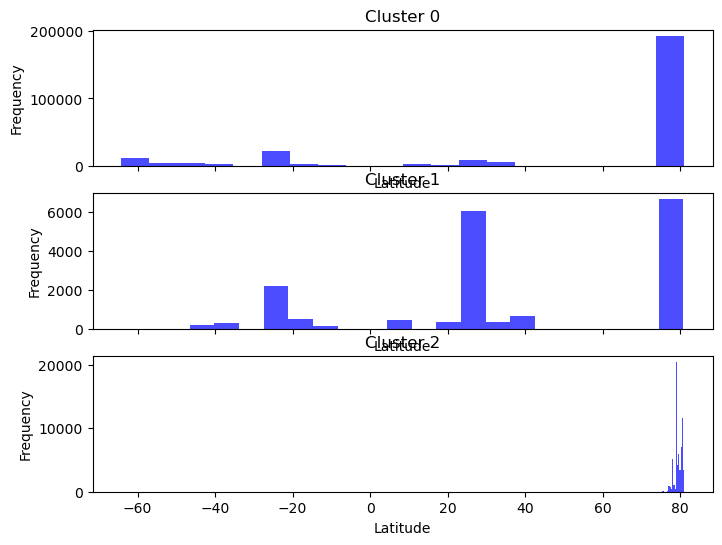

In [59]:
# Create a figure and axis for the histograms
fig, axes = plt.subplots(len(set(merged_df['Cluster'])), figsize=(8, 6), sharex=True)

for cluster_label, ax in zip(set(merged_df['Cluster']), axes):
    # Filter data points for the current cluster
    cluster_data = merged_df[merged_df['Cluster'] == cluster_label]
    
    # Plot a histogram of the latitude values for the current cluster
    ax.hist(cluster_data['latitude'], bins=20, alpha=0.7, color='blue')
    ax.set_title(f'Cluster {cluster_label}')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Frequency')

#plt.tight_layout()
plt.show()


## Plot clusters

The Silhouette Coefficient ranges from -1 to 1 and is calculated for each data point. Here's what the values mean:

Near +1: This indicates that the data point is well inside its own cluster and far from other clusters. A high Silhouette Coefficient suggests that the object is well matched to its own cluster and poorly matched to neighboring clusters.

Near 0: A value close to 0 suggests that the data point is on or very close to the decision boundary between two neighboring clusters. In this case, it could belong to either of the clusters or perhaps to a cluster in between.

Near -1: A value close to -1 indicates that the data point is probably assigned to the wrong cluster. It is far from its own cluster and very close to another cluster, suggesting a poor clustering solution.

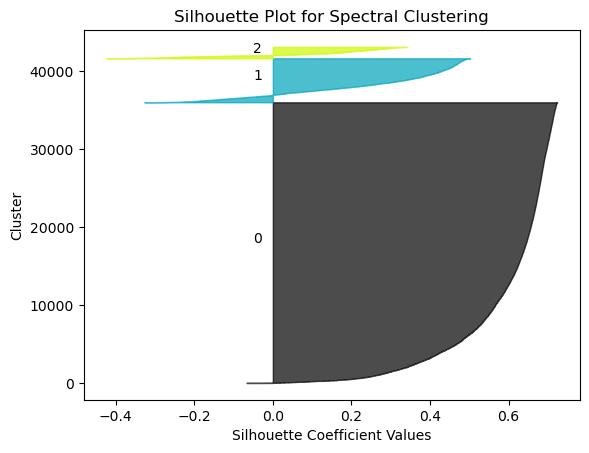

In [60]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

silhouette_avg = silhouette_score(X, cluster_labels)
sample_silhouette_values = silhouette_samples(X, cluster_labels)

# Create a silhouette plot
y_lower = 10
for i in range(len(set(cluster_labels))):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / len(set(cluster_labels)))
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # Add 10 for the next plot

# Add a title and axis labels
plt.title("Silhouette Plot for Spectral Clustering")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster")

# Show the plot
plt.show()

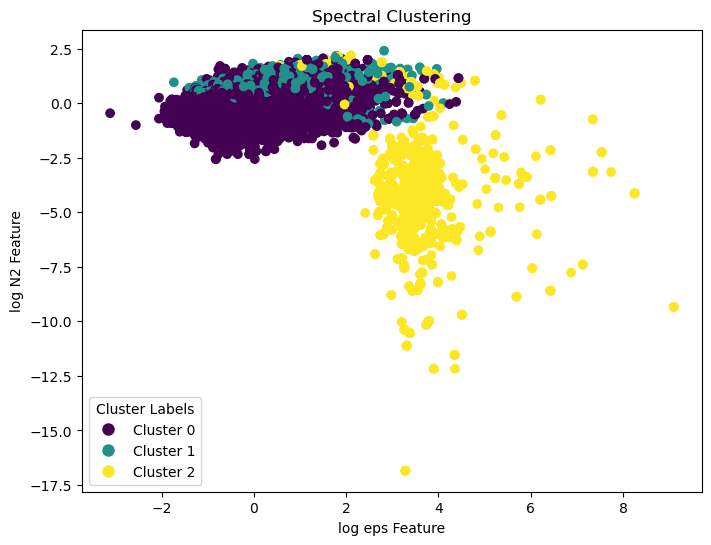

In [61]:
# Select the two features (N2 and T) for plotting
feature_N = X['log_eps']
feature_T = X['log_N2']

# Create a scatter plot with cluster assignments
plt.figure(figsize=(8, 6))
scatter = plt.scatter(feature_N, feature_T, c=cluster_labels, cmap='viridis')

# Get unique cluster labels
unique_labels = list(set(cluster_labels))

# Create custom legend handles with corresponding labels and colors
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.to_rgba(label), markersize=10, label=f'Cluster {label}') for label in unique_labels]

# Set plot titles and labels
plt.title('Spectral Clustering')
plt.xlabel('log eps Feature')
plt.ylabel('log N2 Feature')

# Show the legend and the plot
plt.legend(handles=legend_handles, title="Cluster Labels")
plt.show()


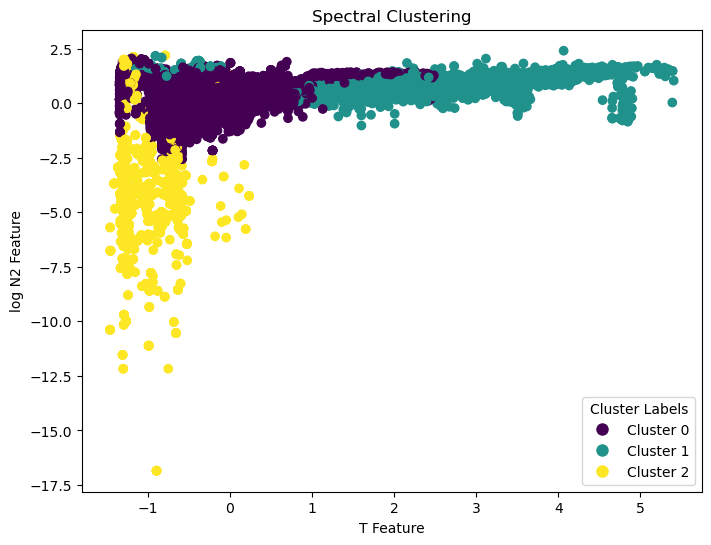

In [62]:
# Select the two features (N2 and T) for plotting
feature_N = X['T']
feature_T = X['log_N2']

# Create a scatter plot with cluster assignments
plt.figure(figsize=(8, 6))
scatter = plt.scatter(feature_N, feature_T, c=cluster_labels, cmap='viridis')

# Get unique cluster labels
unique_labels = list(set(cluster_labels))

# Create custom legend handles with corresponding labels and colors
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.to_rgba(label), markersize=10, label=f'Cluster {label}') for label in unique_labels]

# Set plot titles and labels
plt.title('Spectral Clustering')
plt.xlabel('T Feature')
plt.ylabel('log N2 Feature')

# Show the legend and the plot
plt.legend(handles=legend_handles, title="Cluster Labels")
plt.show()



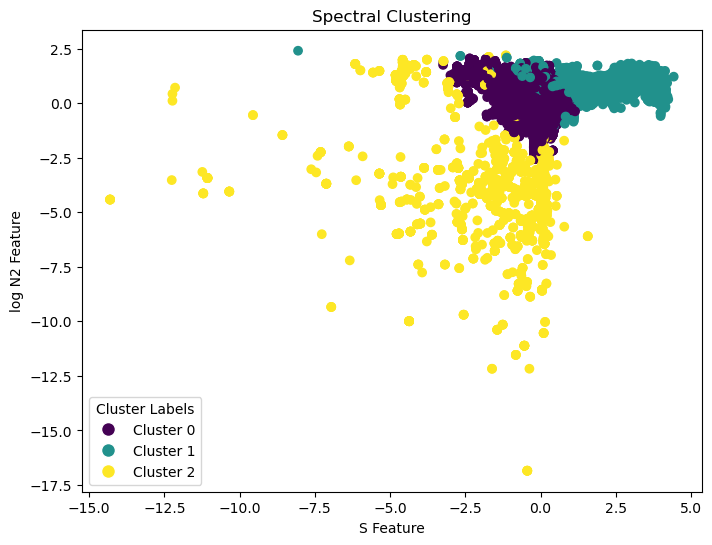

In [63]:
# Select the two features (N2 and T) for plotting
feature_N = X['S']
feature_T = X['log_N2']

# Create a scatter plot with cluster assignments
plt.figure(figsize=(8, 6))
scatter = plt.scatter(feature_N, feature_T, c=cluster_labels, cmap='viridis')

# Get unique cluster labels
unique_labels = list(set(cluster_labels))

# Create custom legend handles with corresponding labels and colors
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.to_rgba(label), markersize=10, label=f'Cluster {label}') for label in unique_labels]

# Set plot titles and labels
plt.title('Spectral Clustering')
plt.xlabel('S Feature')
plt.ylabel('log N2 Feature')

# Show the legend and the plot
plt.legend(handles=legend_handles, title="Cluster Labels")
plt.show()


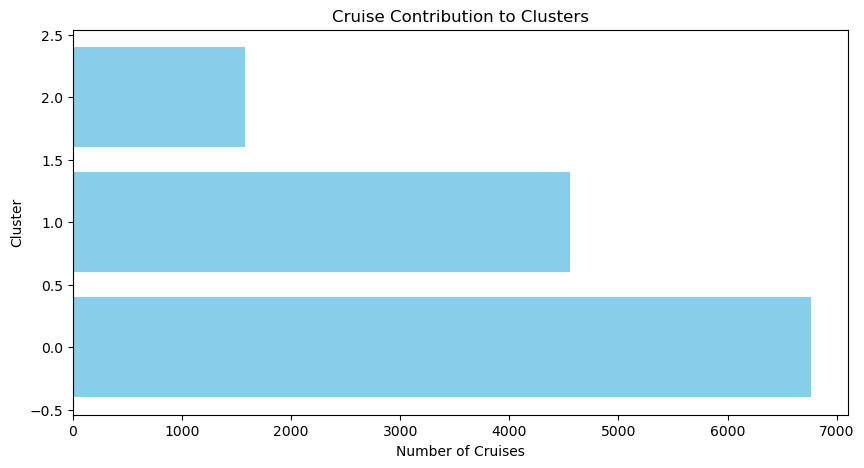

In [64]:
# Count the number of cruises in each cluster
cluster_counts = merged_df['Cluster'].value_counts().sort_index()

# Create a horizontal bar plot
plt.figure(figsize=(10, 5))
plt.barh(cluster_counts.index, cluster_counts.values, color='skyblue')

# Customize the plot
plt.ylabel('Cluster')
plt.xlabel('Number of Cruises')
plt.title('Cruise Contribution to Clusters')

# Show the plot
plt.show()

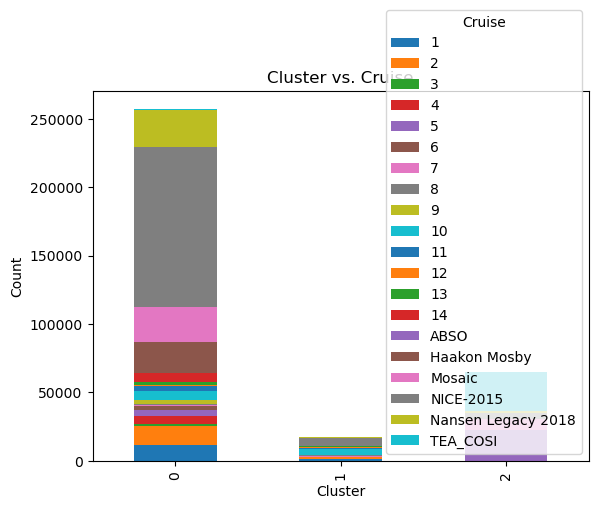

In [64]:
# Bar plot for cluster vs. crisis
cluster_crisis_groups.plot(kind='bar', stacked=True)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster vs. Cruise')
plt.legend(title='Cruise')
plt.show()

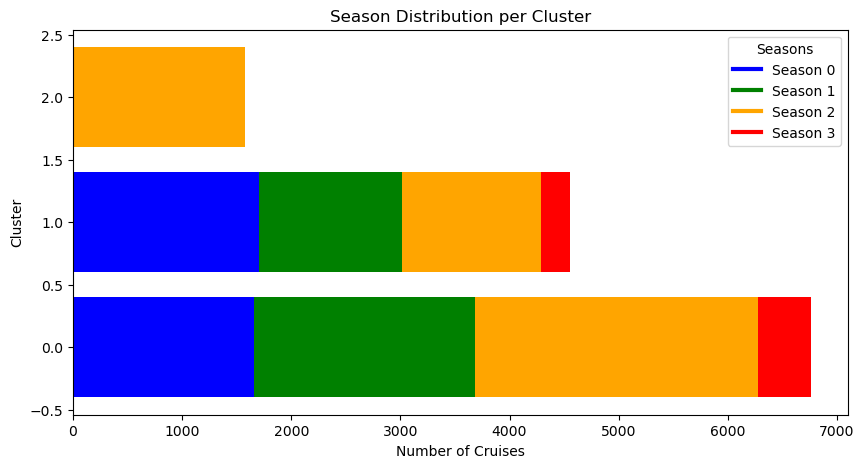

In [ ]:
# Define a color map for seasons
season_colors = {0: 'blue', 1: 'green', 2: 'orange', 3: 'red'}

# Map season values to colors
merged_df['Color'] = merged_df['season'].map(season_colors)

# Count the number of cruises in each cluster for each season
cluster_season_counts = merged_df.groupby(['Cluster', 'season']).size().unstack().fillna(0)

# Create a horizontal bar plot with colored segments for seasons
plt.figure(figsize=(10, 5))
bottom = None

for season in range(4):  # Assuming 4 seasons (0 to 3)
    season_label = f'Season {season}'
    plt.barh(cluster_season_counts.index, cluster_season_counts[season], left=bottom, color=season_colors[season], label=season_label)
    if bottom is None:
        bottom = cluster_season_counts[season]
    else:
        bottom += cluster_season_counts[season]

# Customize the plot
plt.ylabel('Cluster')
plt.xlabel('Number of Cruises')
plt.title('Season Distribution per Cluster')

# Show the legend for season colors
legend_labels = [plt.Line2D([0], [0], color=color, lw=3, label=f'Season {season}') for season, color in season_colors.items()]
plt.legend(handles=legend_labels, title='Seasons')

# Show the plot
plt.show()

## Try 5 clusters

In [66]:
X = X_scaled

from sklearn.cluster import SpectralClustering

# Instantiate the Spectral Clustering model
n_clusters = 5 # The number of clusters to form
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=20) #10
# spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='rbf', n_neighbors=10)

# Fit the Spectral Clustering model to your scaled data
cluster_labels = spectral_clustering.fit_predict(X_scaled)

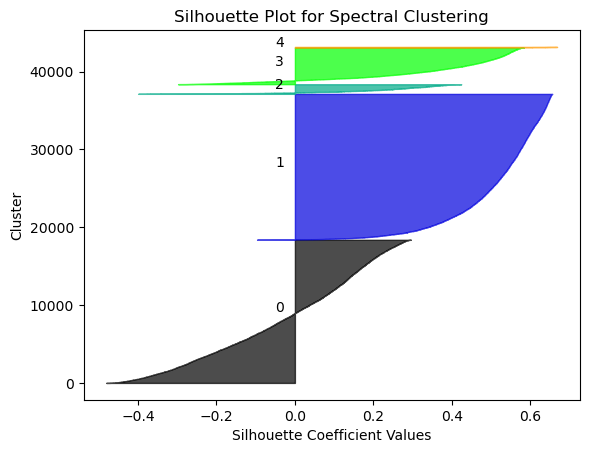

In [89]:
import matplotlib.pyplot as plt
import numpy as np

silhouette_avg = silhouette_score(X, cluster_labels)
sample_silhouette_values = silhouette_samples(X, cluster_labels)

# Create a silhouette plot
y_lower = 10
for i in range(len(set(cluster_labels))):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / len(set(cluster_labels)))
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # Add 10 for the next plot

# Add a title and axis labels
plt.title("Silhouette Plot for Spectral Clustering")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster")

# Show the plot
plt.show()

In [67]:
X_input = X[['S', 'T', 'log_eps', 'log_N2', 'dTdz', 'dSdz']]
# X_output = X[['Cluster']]

# Use the inverse_transform method to anti-scale X_scaled
transformed_df2 = pd.DataFrame(scaler.inverse_transform(X_input), columns=X_input.columns)

# Add cluster labels to the DataFrame
transformed_df2['Cluster'] = spectral_clustering.labels_

# Round the values in the DataFrames to a specific number of decimal places
decimals = 4  # Adjust as needed
data_rounded = data.round(decimals)
transformed_df_rounded = transformed_df2.round(decimals)

# Merge based on multiple columns (A and B)
merged_df2 = transformed_df_rounded.merge(data_rounded, on=['S', 'T', 'log_eps', 'log_N2', 'dSdz', 'dTdz'], how='left')

cluster_crisis_groups2 = merged_df2.groupby(['Cluster', 'cruise']).size().unstack(fill_value=0)
cluster_crisis_groups2

cruise,1,2,3,4,5,6,7,8,9,10,11,12,13,14,ABSO,Haakon Mosby,Mosaic,NICE-2015,Nansen Legacy 2018,TEA_COSI
Cluster,,,,,,,,,,,,,,,,,,,,
0,3638,5726,732,2668,3926,1218,106,1272,2628,32,3094,20,82,4282,0,12783,32061,119968,17562,1173
1,8254,8674,370,3632,506,1550,382,0,842,6432,906,472,1764,2960,0,9394,1562,840,10009,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22743,0,0,2444,752,28313
3,994,1070,0,0,0,168,410,334,4,4532,16,1008,828,0,0,0,0,0,0,0
4,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,9,3902,1020,0


In [81]:
# Analyse cluster 0
cluster_0_data = merged_df2[merged_df2['Cluster'] == 0]
cluster_0_statistics = cluster_0_data.describe()
print(cluster_0_statistics)

                   S              T        log_eps         log_N2  \
count  212971.000000  212971.000000  212971.000000  212971.000000   
mean       34.569424       1.906354      -8.655772      -4.844240   
std         0.631055       2.421656       0.681386       0.768532   
min        30.003100      -1.838500     -10.919400      -8.195800   
25%        34.324600       0.074400      -8.950000      -5.354500   
50%        34.818900       2.341500      -8.714800      -4.861700   
75%        34.984500       3.155200      -8.448000      -4.240200   
max        35.388500      23.005800      -4.744100      -2.454000   

                dTdz           dSdz   Cluster          depth        profile  \
count  212971.000000  212971.000000  212971.0  212971.000000  212971.000000   
mean        0.014893       0.007647       0.0    -414.397739    4529.080889   
std         0.052194       0.014991       0.0    1383.375249   23788.891566   
min        -0.480600      -0.306800       0.0   -5696.000000  

In [80]:
# Analyse cluster 1
cluster_0_data = merged_df2[merged_df2['Cluster'] == 1]
cluster_0_statistics = cluster_0_data.describe()
print(cluster_0_statistics)

                  S             T       log_eps        log_N2          dTdz  \
count  58549.000000  58549.000000  58549.000000  58549.000000  58549.000000   
mean      34.930422      2.953782     -9.984554     -5.821530      0.002035   
std        0.152417      1.526196      0.406667      0.648313      0.007878   
min       34.379500     -0.666000    -12.565800     -9.040900     -0.035300   
25%       34.816500      1.994600    -10.263000     -6.150500      0.000400   
50%       34.932000      2.905300     -9.986600     -5.844800      0.000900   
75%       35.035100      3.582700     -9.767800     -5.421600      0.002700   
max       35.501500      8.520400     -8.317400     -4.449400      0.037200   

               dSdz  Cluster         depth        profile      latitude  
count  58549.000000  58549.0  58549.000000   58549.000000  58549.000000  
mean       0.000576      1.0  -2827.372955    8847.463185     19.477957  
std        0.001165      0.0   2405.195575   37315.497634     52.6

In [79]:
# Analyse cluster 2
cluster_0_data = merged_df2[merged_df2['Cluster'] == 2]
cluster_0_statistics = cluster_0_data.describe()
print(cluster_0_statistics)

                  S             T       log_eps        log_N2          dTdz  \
count  54253.000000  54253.000000  54253.000000  54253.000000  54253.000000   
mean      33.737307     -0.440004     -5.878805    -11.387869      0.000953   
std        1.348744      1.247281      0.793126      3.108049      0.058339   
min       26.284300     -2.371400     -7.405100    -27.977100     -1.613500   
25%       33.174000     -1.494400     -6.301000    -12.806400     -0.005500   
50%       34.204000     -0.806300     -5.945700    -11.153300      0.001000   
75%       34.701000      0.307000     -5.743700     -9.791300      0.021500   
max       35.735200      5.408800     -0.483800     -2.738700      0.217400   

               dSdz  Cluster         depth       profile      latitude  
count  54253.000000  54253.0  54252.000000  54252.000000  54252.000000  
mean       0.033704      2.0    135.655957    214.676417     79.323011  
std        0.110081      0.0    113.844317    321.993764      0.92156

In [82]:
# Analyse cluster 3
cluster_0_data = merged_df2[merged_df2['Cluster'] == 3]
cluster_0_statistics = cluster_0_data.describe()
print(cluster_0_statistics)

                 S            T      log_eps       log_N2         dTdz  \
count  9364.000000  9364.000000  9364.000000  9364.000000  9364.000000   
mean     35.849827    14.853897    -9.333815    -4.687384     0.025160   
std       0.543012     4.586263     0.724071     0.429652     0.022218   
min      34.711700     7.018300   -11.198600    -6.766800    -0.051100   
25%      35.392400    11.203800    -9.864600    -4.944000     0.012100   
50%      35.703200    14.178600    -9.450900    -4.788900     0.017500   
75%      36.289300    17.728300    -8.950100    -4.471500     0.029000   
max      37.435700    29.165300    -5.424500    -3.228400     0.225600   

              dSdz  Cluster        depth      profile     latitude  
count  9364.000000   9364.0  9364.000000  9364.000000  9364.000000  
mean      0.002999      3.0 -4314.606151   438.916062    14.890805  
std       0.003570      0.0  1450.393353   213.588019    21.726924  
min      -0.040300      3.0 -5904.000000     0.000000   -

In [86]:
# Analyse cluster 4
cluster_0_data = merged_df2[merged_df2['Cluster'] == 4]
cluster_0_statistics = cluster_0_data.describe()
print(cluster_0_statistics)

                 S            T      log_eps       log_N2         dTdz  \
count  4933.000000  4933.000000  4933.000000  4933.000000  4933.000000   
mean     34.565308     1.526706    -7.863704    -3.409980     0.427964   
std       0.238951     1.402259     0.593935     0.254592     0.147874   
min      33.215200    -1.417700    -8.754000    -3.994800     0.279900   
25%      34.439100    -0.067600    -8.345900    -3.550500     0.301000   
50%      34.602400     1.741100    -7.942800    -3.408300     0.362200   
75%      34.694300     2.510000    -7.585800    -3.184200     0.644400   
max      36.395100    19.565400    -6.546700    -2.770300     0.842800   

              dSdz  Cluster        depth      profile     latitude  
count  4933.000000   4933.0  4933.000000  4933.000000  4933.000000  
mean      0.068094      4.0    43.776809  1265.573890    80.523849  
std       0.044690      0.0    41.548419   639.658711     2.359936  
min       0.019900      4.0 -1517.000000    19.000000   -

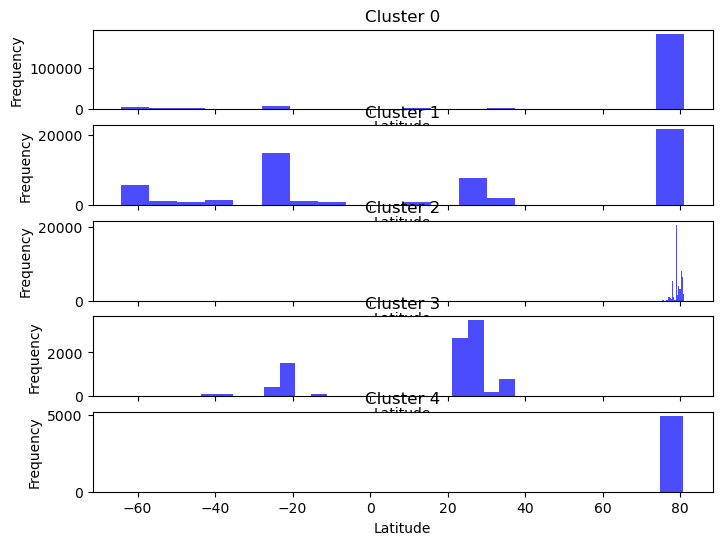

In [68]:
# Create a figure and axis for the histograms
fig, axes = plt.subplots(len(set(merged_df2['Cluster'])), figsize=(8, 6), sharex=True)

for cluster_label, ax in zip(set(merged_df2['Cluster']), axes):
    # Filter data points for the current cluster
    cluster_data2 = merged_df2[merged_df2['Cluster'] == cluster_label]
    
    # Plot a histogram of the latitude values for the current cluster
    ax.hist(cluster_data2['latitude'], bins=20, alpha=0.7, color='blue')
    ax.set_title(f'Cluster {cluster_label}')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Frequency')

#plt.tight_layout()
plt.show()

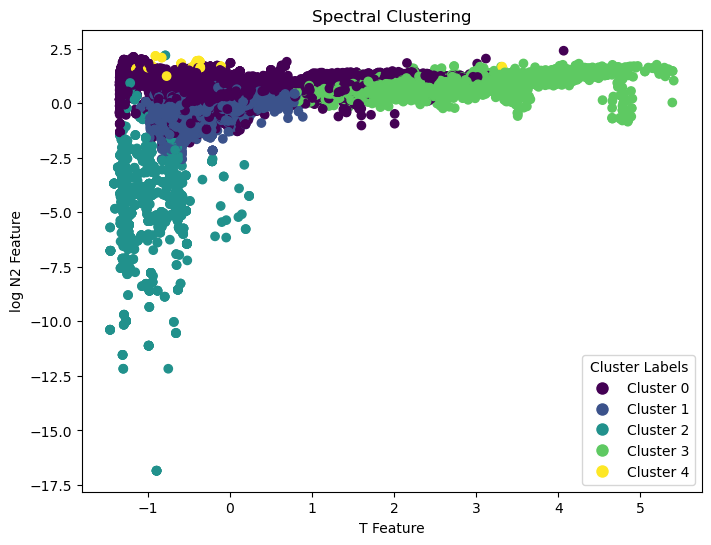

In [69]:
# Select the two features (N2 and T) for plotting
feature_N = X['T']
feature_T = X['log_N2']

# Create a scatter plot with cluster assignments
plt.figure(figsize=(8, 6))
scatter = plt.scatter(feature_N, feature_T, c=cluster_labels, cmap='viridis')

# Get unique cluster labels
unique_labels = list(set(cluster_labels))

# Create custom legend handles with corresponding labels and colors
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.to_rgba(label), markersize=10, label=f'Cluster {label}') for label in unique_labels]

# Set plot titles and labels
plt.title('Spectral Clustering')
plt.xlabel('T Feature')
plt.ylabel('log N2 Feature')

# Show the legend and the plot
plt.legend(handles=legend_handles, title="Cluster Labels")
plt.show()

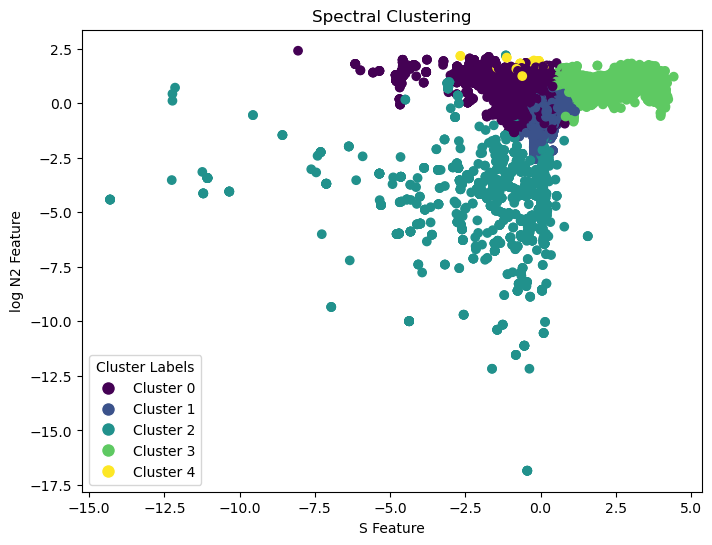

In [87]:
# Select the two features (N2 and T) for plotting
feature_N = X['S']
feature_T = X['log_N2']

# Create a scatter plot with cluster assignments
plt.figure(figsize=(8, 6))
scatter = plt.scatter(feature_N, feature_T, c=cluster_labels, cmap='viridis')

# Get unique cluster labels
unique_labels = list(set(cluster_labels))

# Create custom legend handles with corresponding labels and colors
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.to_rgba(label), markersize=10, label=f'Cluster {label}') for label in unique_labels]

# Set plot titles and labels
plt.title('Spectral Clustering')
plt.xlabel('S Feature')
plt.ylabel('log N2 Feature')

# Show the legend and the plot
plt.legend(handles=legend_handles, title="Cluster Labels")
plt.show()


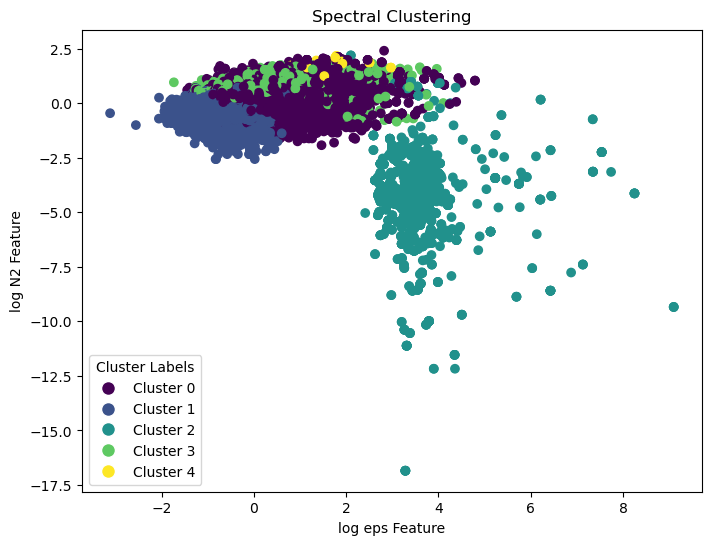

In [88]:
# Select the two features (N2 and T) for plotting
feature_N = X['log_eps']
feature_T = X['log_N2']

# Create a scatter plot with cluster assignments
plt.figure(figsize=(8, 6))
scatter = plt.scatter(feature_N, feature_T, c=cluster_labels, cmap='viridis')

# Get unique cluster labels
unique_labels = list(set(cluster_labels))

# Create custom legend handles with corresponding labels and colors
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.to_rgba(label), markersize=10, label=f'Cluster {label}') for label in unique_labels]

# Set plot titles and labels
plt.title('Spectral Clustering')
plt.xlabel('log eps Feature')
plt.ylabel('log N2 Feature')

# Show the legend and the plot
plt.legend(handles=legend_handles, title="Cluster Labels")
plt.show()


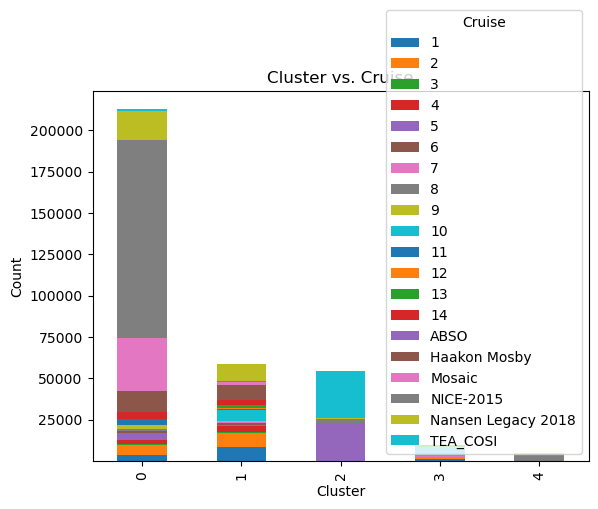

In [70]:
# Bar plot for cluster vs. crisis
cluster_crisis_groups2.plot(kind='bar', stacked=True)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster vs. Cruise')
plt.legend(title='Cruise')
plt.show()